In [1]:
import kagglehub
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout
)

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications import MobileNetV3Large
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

In [2]:
def plot_history(history):
  """
  Funkce na vykreslení dat z objectu history -> vrací ho metoda fit keras modelu
  """
  # plot the Loss curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)

  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  # plot the Accuracy curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
  plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)
  plt.show()

## Načtení a preprocessing dat

In [3]:
# Stáhnout aktuální verzi datasetu
# Pozor -> musíte vytvořit složku .kaggle a do ní vložit svůj kaggle.json soubor s přístupy
# návod https://www.kaggle.com/docs/api#authentication
path = kagglehub.dataset_download("niteshfre/chessman-image-dataset")

100%|██████████| 57.6M/57.6M [00:06<00:00, 9.09MB/s]

Extracting model files...


In [4]:
# data se stáhly sem -> ručně jsem hledal, od jaké úrovně složek už jsou data
slozky_figurky = os.listdir(f"{path}/Chessman-image-dataset/Chess")
slozky_figurky

['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

In [5]:
# potřebuji načíst fotky, k fotkám labely a uložit si, jaký label patří k jaké figurce
X = []
y = []
encoding = {}
# pro každou složku s figurkami
for index, figurka in enumerate(slozky_figurky):
  # uložíme si přiřazení číel k labelům y
  encoding[index] = figurka
  # složka s fotkami kontrétních figurek
  folder_path = os.path.join(f"{path}/Chessman-image-dataset/Chess", figurka)

  # sem načteme fotky konkrétních figurek
  image_list = []
  # pro každý soubor ze složky
  for filename in os.listdir(folder_path):
    # pokud se jedná o .jpg
    if filename.endswith(".jpg"):
        # cesta ke kokrétnímu souboru
        img_path = os.path.join(folder_path, filename)
        # načti obrázek ze souboru
        img = Image.open(img_path)
        # Změň rozlišení na 224x224 -> všechny budou mít stejný rozměr
        img_resized = img.resize((224, 224))
        # převeď na numpy array
        img_array = np.array(img_resized)
        # přidat do listu k ostatním
        image_list.append(img_array)
  # do X přidej obrázky z další složky (respektive figurky)
  X += image_list
  # vytvoříme list s labely (rovnou jako čísla, ať nemusíme pozdějí dělat encoding)
  # přiřazení čísel k labelům máme v proměnné 'encoding'
  y += [index] * len(image_list)

In [6]:
# převést list s numpy arrayi pro každou figurku na numpy array (tenzor)
X = np.stack(X)
# převést list y na numpy array
y = np.array(y)

In [7]:
# transfer learning viz. níže -> zvolili jsme Mobilnetv3 jako základ
# ten vyžaduje hodnoty pixelů v rozmezí od 0-255 -> neškálovat!
X_not_scaled = X.copy()

In [8]:
# škálujeme pro náš vlastní model
X = X / 255

In [9]:
# rozdělení, trénink test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
# one hot encoding y -> musí sedět rozměr s výstupem softmax vrstvy
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
early = EarlyStopping(
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # pokud se nezlepší alespoň o 0.3%
    min_delta=0.003,
    # za posledních 10 epoch
    patience=10,
    # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
    restore_best_weights=True,
    start_from_epoch = 50
)

save = ModelCheckpoint(
    # kam uložit model
    filepath="best_model.keras",
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
    save_best_only=True,
    # ulož do jednoho souboru architekturu i váhy
    save_weights_only=False,
    # po každé epoše
    save_freq="epoch"
)

## Vlastní neuronka

In [11]:
# vytvoříme vlastní model - inspirace VGG16 architektura
model = Sequential()
# vstup musí sedět na X
model.add(Input(shape=X_train.shape[1:]))
# blok konvoluce s poolingem
model.add(Conv2D(16, (3, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D())
# převést na vektor
model.add(Flatten())
# regularizace proti overfittingu
model.add(Dropout(0.2))
# výstupní vrstva -> multiclass single label -> softmax
model.add(Dense(len(slozky_figurky), activation="softmax"))

# kompilace
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │       559,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 564,966 (2.16 MB)

 Trainable params: 564,966 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=32, callbacks=[early, save])

Epoch 1/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - accuracy: 0.1816 - loss: 18.1757 - val_accuracy: 0.1613 - val_loss: 4.0956
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.2605 - loss: 2.5053 - val_accuracy: 0.1828 - val_loss: 1.9198
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.4676 - loss: 1.5138 - val_accuracy: 0.2903 - val_loss: 1.8582
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5183 - loss: 1.2903 - val_accuracy: 0.2903 - val_loss: 1.7115
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.5374 - loss: 1.6922 - val_accuracy: 0.2796 - val_loss: 2.0551
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.7218 - loss: 0.9781 - val_accuracy: 0.4086 - val_loss: 1.5509
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.8355 - loss: 0.6721 - val_accuracy: 0.3978 - val_loss: 1.6093
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.8434 - loss: 0.5925 -

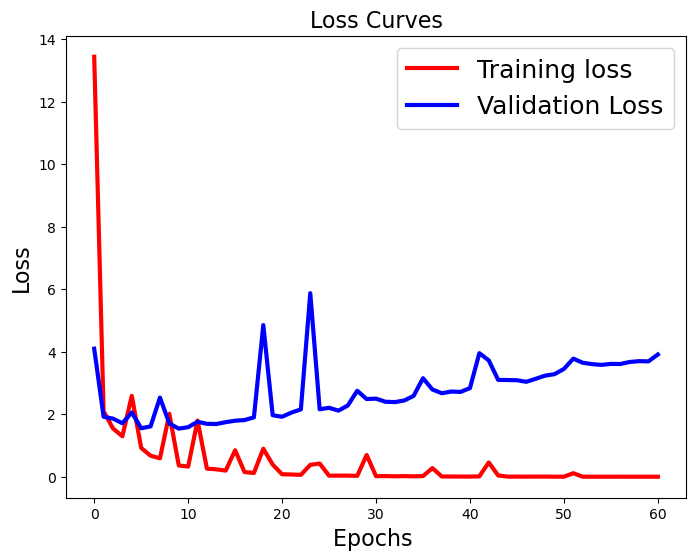

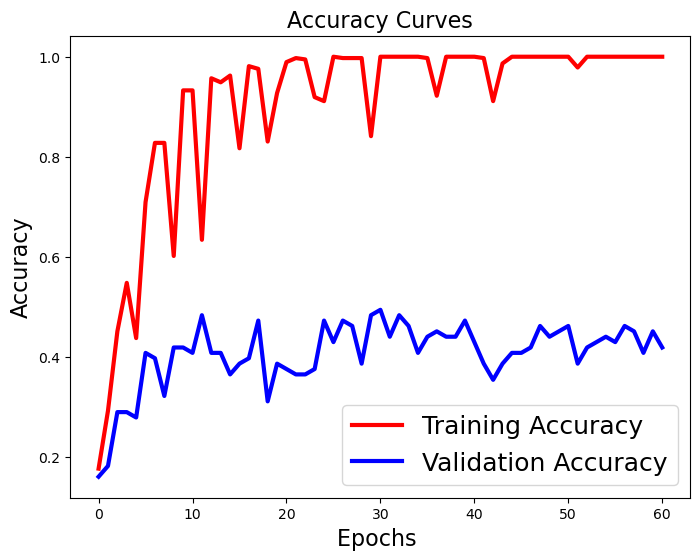

In [13]:
plot_history(history)

## Transfer learning

In [14]:
# vytvořit trénovací sadu z nenaškálovanýách dat
X_train, X_test, y_train, y_test = train_test_split(
    X_not_scaled, y, test_size=0.2, stratify=y, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
# načtení konvoluční featur extraction části MobilnetV3
base_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
# první MobilnetV3 konvoluční část
x = base_model.output
# převod na vektor s redukcí dat pomocí poolingu
x = GlobalAveragePooling2D()(x)
# stejná klasifikační vrstva jako u vlastní neuronky
# regularizace
x = Dropout(0.2)(x)
# softmax vrstva podle úlohy
predictions = Dense(len(slozky_figurky), activation="softmax")(x)

# spojíme do kupy
model = Model(inputs=base_model.input, outputs=predictions)

# nepřetrénovávat MobilnetV3 vrstvy -> učíme pouze klasifikátor
for layer in base_model.layers:
    layer.trainable = False

# kompilace stejná jako u vlastní neuronky
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,002,118 (11.45 MB)

 Trainable params: 5,766 (22.52 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [17]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=32, callbacks=[early, save])

Epoch 1/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.1830 - loss: 2.2490 - val_accuracy: 0.3763 - val_loss: 1.5318
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 710ms/step - accuracy: 0.4475 - loss: 1.4537 - val_accuracy: 0.4946 - val_loss: 1.2949
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 799ms/step - accuracy: 0.5104 - loss: 1.2222 - val_accuracy: 0.5914 - val_loss: 1.1527
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6110 - loss: 1.0652 - val_accuracy: 0.6452 - val_loss: 1.0108
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 890ms/step - accuracy: 0.6766 - loss: 0.9136 - val_accuracy: 0.6774 - val_loss: 0.9506
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 898ms/step - accuracy: 0.7125 - loss: 0.8072 - val_accuracy: 0.7312 - val_loss: 0.8577
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 647ms/step - accuracy: 0.7947 - loss: 0.6715 - val_accuracy: 0.7097 - val_loss: 0.8108
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 702ms/step - accuracy: 0.8119 - loss: 0.6443 - va

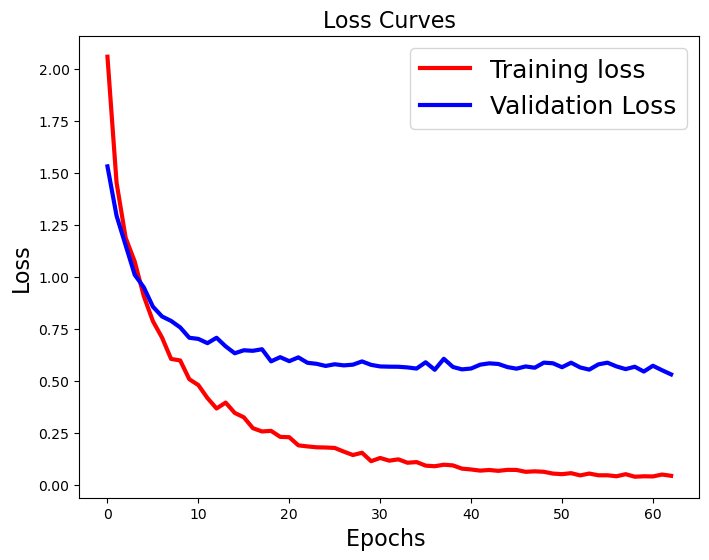

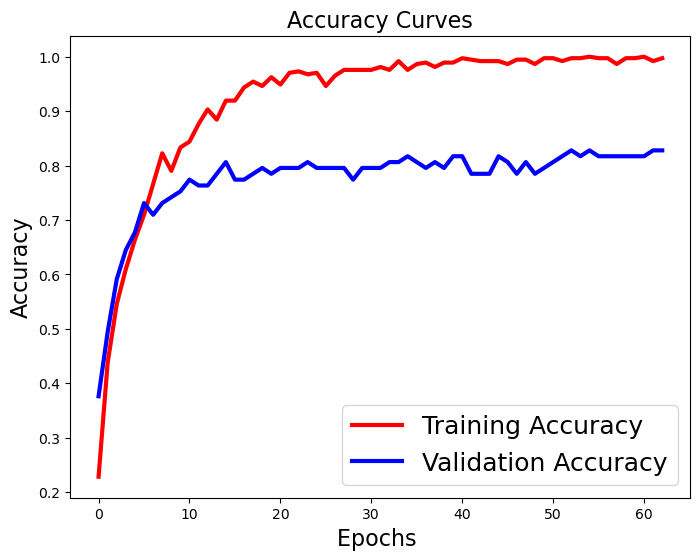

In [18]:
plot_history(history)